In [1]:

from ngsolve import *
from ngsolve.webgui import Draw


import numpy as np
import matplotlib.pyplot as plt

from newtonmethod import NewtonWithLinesearch
SetNumThreads(4)

import netgen.occ as ngocc
from netgen.meshing import MeshingParameters
from netgen.webgui import Draw as DrawGeo

In [2]:

rect = ngocc.WorkPlane().Rectangle(100,100).Face()
circ = ngocc.WorkPlane().Circle(0,0,10).Face()
circ.maxh=2
plate = (rect-circ).Extrude(10)

plate.faces.Max(ngocc.X).name = "force"
plate.faces.Min(ngocc.X).name = "symx"
plate.faces.Min(ngocc.Y).name = "symy"
plate.faces.Min(ngocc.Z).name = "symz"

geo = ngocc.OCCGeometry(plate)

mesh = Mesh(geo.GenerateMesh(MeshingParameters(maxh=10, grading=0.1)))

order = 2
mesh.Curve(order)
Draw(mesh)

WebGuiWidget(value={'gui_settings': {}, 'ngsolve_version': '6.2.2402-40-g3ac4c9abc', 'mesh_dim': 3, 'order2d':…

BaseWebGuiScene

In [3]:
# Young's modulus
Emod = 206900

# Poisson's ratio
nu = 0.29

lam = Emod*nu/(1+nu)/(1-2*nu)
mu = Emod/2/(1+nu)

# Hardening parameter
H = 1.
nu_H = 0.5
mu_H = H/2/(1+nu_H)

# Yield stress
sigma_Y = 450

loadpar = Parameter(0)


In [4]:
fespace_u = VectorH1(mesh, order=order, dirichletx="symx", dirichlety="symy", dirichletz="symz")
fespace_p = MatrixValued(L2(mesh, order=order-1), symmetric=True, deviatoric=True)
fespace_lag = FESpace("number", mesh, definedon=mesh.Boundaries("force"))

fespace = fespace_u * fespace_p * fespace_lag

q = GridFunction(fespace)
u, p, f = q.components

q0 = GridFunction(fespace)
u0, p0, f0 = q0.components

In [5]:
def NormReg(p, alpha=1e-6):
    return sqrt(InnerProduct(p,p)+alpha**2)

In [6]:
u_, p_, f_ = fespace.TrialFunction()
deltau_, deltap_, deltaf_ = fespace.TestFunction()

strain_ = Sym(Grad(u_))
strain_el_ = strain_ - p_

psi_el = mu*InnerProduct(strain_el_,strain_el_) + lam/2*Trace(strain_el_)**2

psi_p = mu_H*InnerProduct(p_,p_)

pdot_ = p_ - p0


a = BilinearForm(fespace, eliminate_internal=True)
a += SymbolicEnergy(psi_el + psi_p)
a += SymbolicBFI( sqrt(2/3)*sigma_Y*InnerProduct(pdot_, deltap_)/NormReg(pdot_), bonus_intorder=-2)
a += SymbolicEnergy(f_*(loadpar-u_[0]), definedon=mesh.Boundaries("force"))


In [7]:
flist = [0]
ulist = [0]
hv = q0.vec.CreateVector()

maxdisp = 0.1
for l in np.linspace(0,1,11)[1:]:
    print(f"mean x-displacement {l*maxdisp}:")
    hv.data = q.vec - q0.vec
    q0.vec.data = q.vec
    q.vec.data += hv

    loadpar.Set(l*maxdisp)
    NewtonWithLinesearch(a, q.vec)

    flist.append(f.vec[0])
    ulist.append(l*maxdisp)


mean x-displacement 0.010000000000000002:
initial residual 9.999999999999963
newton step  1  res  74.09128511983413 damping 1
newton step  2  res  0.00042664759882529984 damping 1
newton step  3  res  9.117346323778928e-11 damping 1
newtonsteps:  3 , res  9.117346323778928e-11  <  1e-06 * 74.09128511983413
mean x-displacement 0.020000000000000004:
initial residual 72115.98598391058
newton step  1  res  295.8835576452823 damping 1
newton step  2  res  0.013890514742786242 damping 1
newtonsteps:  2 , res  0.013890514742786242  <  1e-06 * 72115.98598391058
mean x-displacement 0.030000000000000006:
initial residual 72088.7314029538
newton step  1  res  519.1060938160882 damping 1
newton step  2  res  0.06952665550198124 damping 1
newtonsteps:  2 , res  0.06952665550198124  <  1e-06 * 72088.7314029538
mean x-displacement 0.04000000000000001:
initial residual 72061.15167870685
newton step  1  res  746.5835129546807 damping 1
newton step  2  res  0.22449878923122732 damping 1
newton step  3  

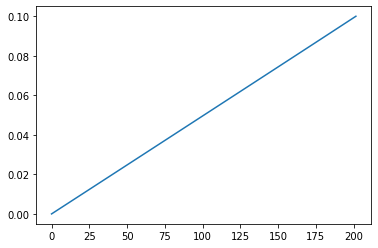

In [8]:
plt.plot(flist, ulist)

In [9]:
Draw(BoundaryFromVolumeCF(p[0]), mesh, "p")

WebGuiWidget(value={'gui_settings': {}, 'ngsolve_version': '6.2.2402-40-g3ac4c9abc', 'mesh_dim': 3, 'order2d':…

BaseWebGuiScene

mean x-displacement 0.11000000000000001:
initial residual 71697.35717083827
newton step  1  res  2764.68829237259 damping 1
newton step  2  res  116.15394207129088 damping 1
newton step  3  res  48.20194927703964 damping 1
newton step  4  res  15.172882972221819 damping 1
newton step  5  res  2.847888576101715 damping 1
newton step  6  res  0.23297649771540996 damping 1
newton step  7  res  0.0028667118518226732 damping 1
newtonsteps:  7 , res  0.0028667118518226732  <  1e-06 * 71697.35717083827
mean x-displacement 0.12:
initial residual 71550.29725696308
newton step  1  res  3179.0136212154002 damping 1
newton step  2  res  150.86181361083254 damping 1
newton step  3  res  56.67294336381653 damping 1
newton step  4  res  16.23604269020797 damping 1
newton step  5  res  3.046700441720451 damping 1
newton step  6  res  0.25225239433088703 damping 1
newton step  7  res  0.005090538759099571 damping 1
newtonsteps:  7 , res  0.005090538759099571  <  1e-06 * 71550.29725696308
mean x-displac

WebGuiWidget(value={'gui_settings': {}, 'ngsolve_version': '6.2.2402-40-g3ac4c9abc', 'mesh_dim': 3, 'order2d':…

BaseWebGuiScene

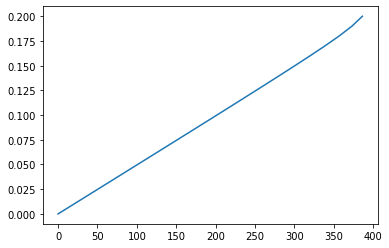

In [10]:
for l in np.linspace(1,2,11)[1:]:
    print(f"mean x-displacement {l*maxdisp}:")
    hv.data = q.vec - q0.vec
    q0.vec.data = q.vec
    q.vec.data += hv

    loadpar.Set(l*maxdisp)
    NewtonWithLinesearch(a, q.vec)

    flist.append(f.vec[0])
    ulist.append(l*maxdisp)

plt.plot(flist, ulist)
Draw(BoundaryFromVolumeCF(p[0]), mesh, "p")

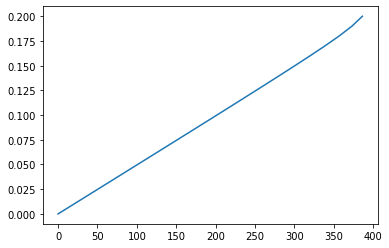

In [11]:
plt.plot(flist, ulist)

In [12]:
Draw(BoundaryFromVolumeCF(p[0]), mesh, "p")

WebGuiWidget(value={'gui_settings': {}, 'ngsolve_version': '6.2.2402-40-g3ac4c9abc', 'mesh_dim': 3, 'order2d':…

BaseWebGuiScene

In [13]:
for l in np.linspace(2,3,11)[1:]:
    print(f"mean x-displacement {l*maxdisp}:")
    hv.data = q.vec - q0.vec
    q0.vec.data = q.vec
    q.vec.data += hv

    loadpar.Set(l*maxdisp)
    NewtonWithLinesearch(a, q.vec)

    flist.append(f.vec[0])
    ulist.append(l*maxdisp)

plt.plot(flist, ulist)
Draw(BoundaryFromVolumeCF(Norm(p)), mesh, "p")

mean x-displacement 0.21000000000000002:
initial residual 58638.145350643485
newton step  1  res  18608.407505381307 damping 1
newton step  2  res  9153.013862865433 damping 1
newton step  3  res  3899.367434710667 damping 1
newton step  4  res  1138.6638157494972 damping 1
newton step  5  res  193.46368690080124 damping 1
newton step  6  res  16.63373647127846 damping 1
newton step  7  res  0.29250754526020084 damping 1
newton step  8  res  0.00018769351256575612 damping 1
newtonsteps:  8 , res  0.00018769351256575612  <  1e-06 * 58638.145350643485
mean x-displacement 0.22000000000000003:
initial residual 49069.29702463709
newton step  1  res  16068.032133211376 damping 1
newton step  2  res  7339.037261169985 damping 1
newton step  3  res  2502.447978986826 damping 1
newton step  4  res  591.8461944853105 damping 1
newton step  5  res  86.10021113709932 damping 1
newton step  6  res  5.268502623209643 damping 1
newton step  7  res  0.040665631495002 damping 1
newtonsteps:  7 , res  0

WebGuiWidget(value={'gui_settings': {}, 'ngsolve_version': '6.2.2402-40-g3ac4c9abc', 'mesh_dim': 3, 'order2d':…

BaseWebGuiScene